In [3]:
import pandas as pd

df = pd.read_csv('train.csv')   
# get info about the dataset
df.describe()

,Unnamed: 0,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,Weight_kg,GCS,...,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,mortality_90d
count,198433.000000,198433.000000,198433.000000,1.984330e+05,198433.000000,198433.000000,198433.000000,198433.000000,198433.000000,198433.000000,...,198433.000000,198433.000000,198433.000000,198433.000000,198433.000000,198433.000000,198433.000000,198433.000000,198433.000000,198433.000000
mean,123775.882278,8.243306,249865.365539,5.738789e+09,0.443374,23554.200312,3.941300,0.073592,83.105959,12.747463,...,0.032906,0.048757,7953.987634,271.626119,6357.835741,315.668642,1593.211322,5.617206,1.638472,0.208826
std,71599.069600,5.056748,28889.323071,9.178718e+08,0.496784,6098.069753,2.146197,0.261106,24.358361,3.271460,...,0.156366,0.306607,11162.131064,528.768691,12095.254420,366.408586,11067.523222,3.435025,1.047920,0.406471
min,7.000000,1.000000,200011.000000,4.116043e+09,0.000000,6582.422234,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-327907.283333,0.000000,0.000000,0.000000
25%,61548.000000,4.000000,224659.000000,4.949478e+09,0.000000,19525.200417,2.000000,0.000000,66.900000,11.000000,...,0.000000,0.000000,1601.667600,0.000000,779.000000,70.000000,-1156.000000,3.000000,1.000000,0.000000
50%,124129.000000,8.000000,250246.000000,5.741600e+09,0.000000,24053.917963,4.000000,0.000000,79.600000,14.875000,...,0.000000,0.000000,4790.000000,53.666667,2420.000000,220.000000,1000.000000,5.000000,2.000000,0.000000
75%,185946.000000,12.000000,274811.000000,6.537107e+09,1.000000,28372.996238,5.000000,0.000000,95.000000,15.000000,...,0.000000,0.000000,9872.222650,312.500000,6340.000000,440.000000,4717.634250,8.000000,2.000000,0.000000
max,247591.000000,20.000000,299995.000000,7.593608e+09,1.000000,33383.850000,14.000000,1.000000,282.000000,15.000000,...,23.289000,46.488000,172323.496018,9992.674267,330130.000000,10900.000000,157842.851467,23.000000,4.000000,1.000000


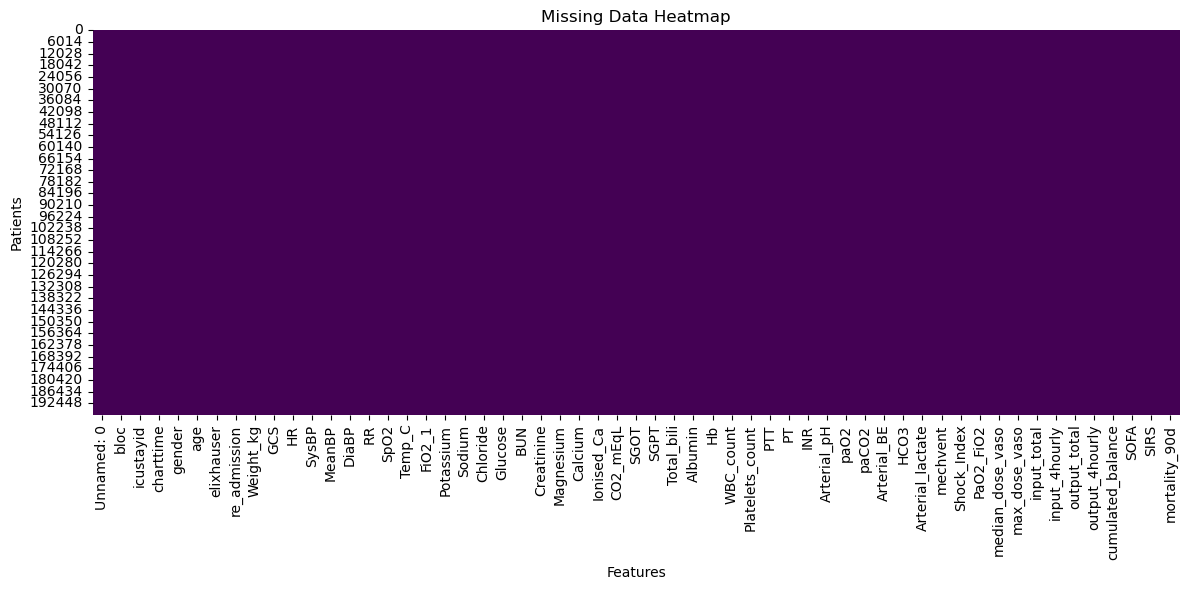

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'your_dataframe' with your actual DataFrame
df = pd.read_csv("train.csv")

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.xlabel("Features")
plt.ylabel("Patients")
plt.tight_layout()
plt.show()


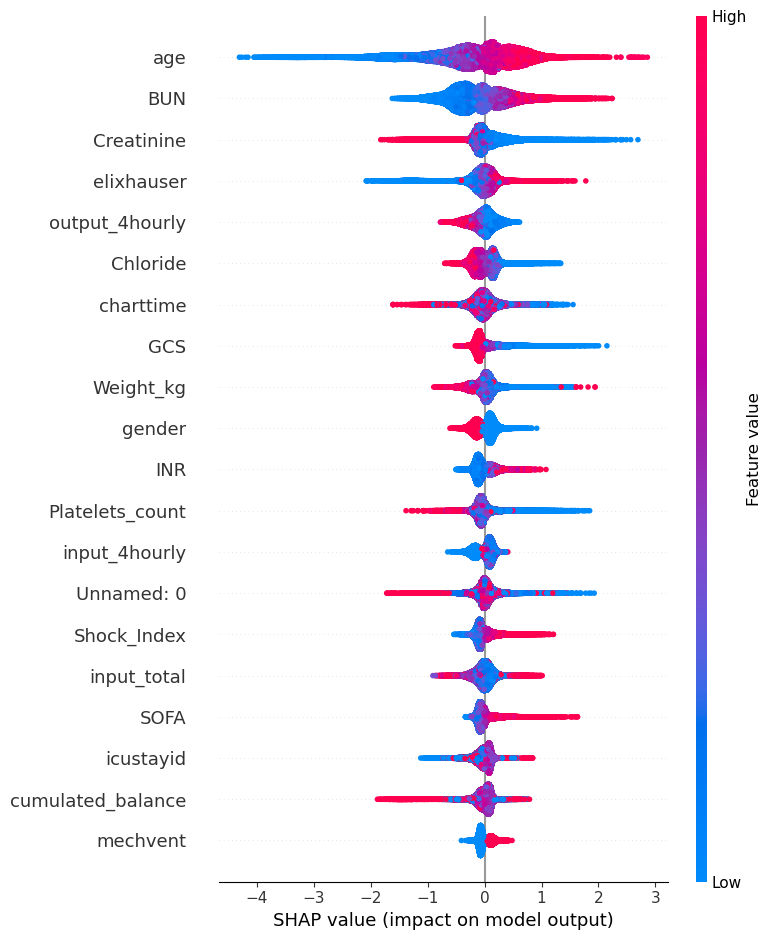

In [8]:
import shap
import xgboost as xgb

# Load data and model
X = pd.read_csv("train.csv")
#target = mortality_90d
y = X.pop("mortality_90d")
model = xgb.XGBClassifier().fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot
shap.summary_plot(shap_values, X)


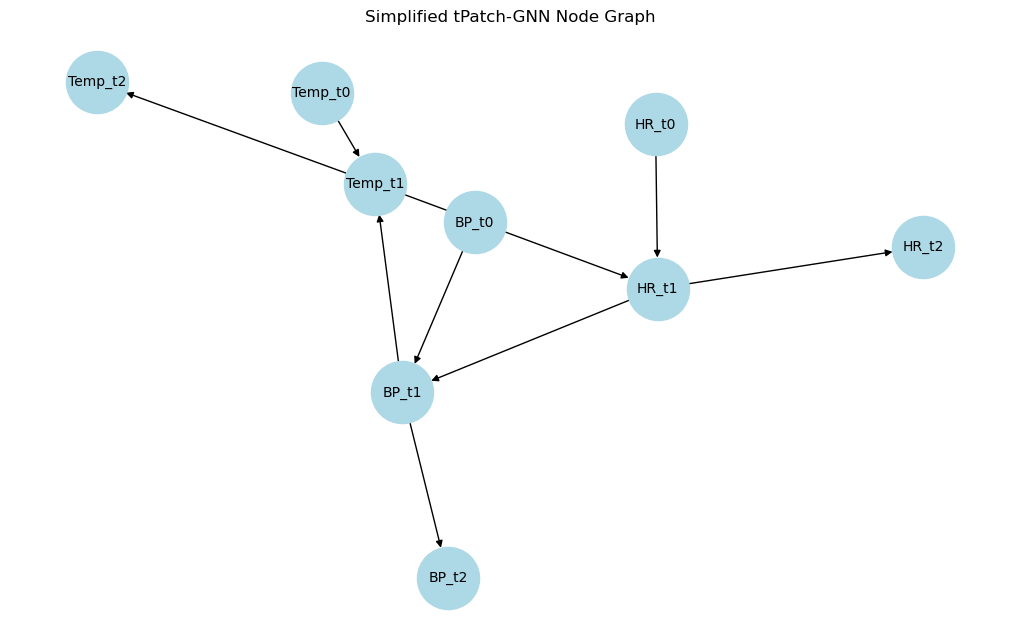

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes: features at different time points
for t in range(3):  # time steps
    for f in ['HR', 'BP', 'Temp']:
        G.add_node(f"{f}_t{t}", label=f"{f} (t={t})")

# Connect time steps (temporal edges)
for t in range(2):
    for f in ['HR', 'BP', 'Temp']:
        G.add_edge(f"{f}_t{t}", f"{f}_t{t+1}")

# Add feature interactions (spatial edges)
G.add_edge('HR_t1', 'BP_t1')
G.add_edge('BP_t1', 'Temp_t1')
G.add_edge('Temp_t1', 'HR_t1')

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)
plt.title("Simplified tPatch-GNN Node Graph")
plt.show()


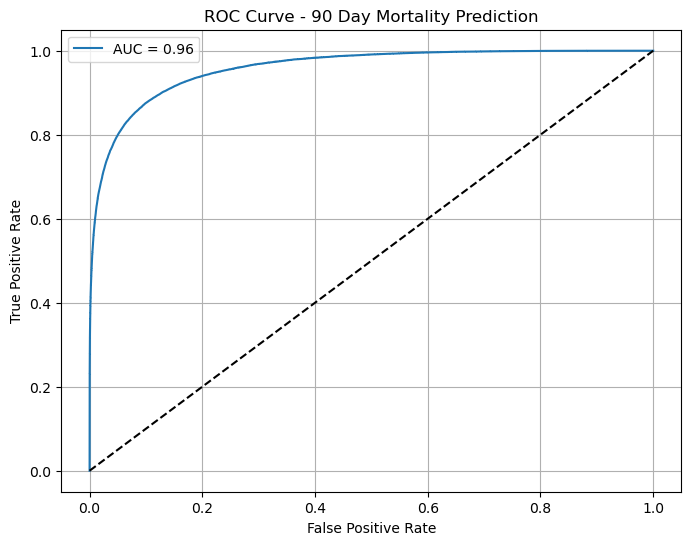

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# golden truth is mortality_90d
# Assuming you have a trained model and test data
X_test = pd.read_csv("train.csv").drop(columns=["mortality_90d"])
# Assuming the model is already trained
model = xgb.XGBClassifier().fit(X, y)  # Train the model on the training data
y_test = pd.read_csv("train.csv")["mortality_90d"]
y_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class


# Assuming y_test and y_probs already exist
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - 90 Day Mortality Prediction")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from graphviz import Digraph

dot = Digraph()

dot.node('A', 'Data Loader')
dot.node('B', 'tPatch-GNN Imputer')
dot.node('C', 'XGBoost Mortality Predictor')
dot.node('D', 'LLM Interface')
dot.node('E', 'Clinician')

dot.edges(['AB', 'BC', 'CD', 'DE'])

dot.render('system_architecture', format='png', cleanup=False)


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

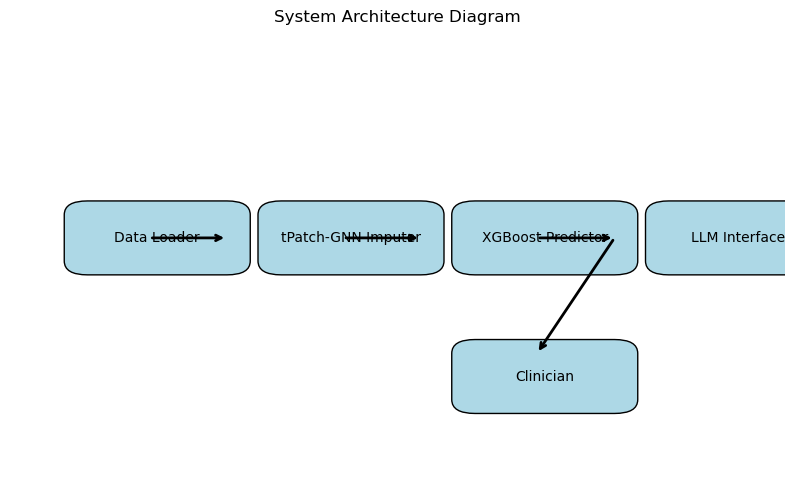

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 6))

# Draw boxes
boxes = {
    "Data Loader": (0.1, 0.5),
    "tPatch-GNN Imputer": (0.35, 0.5),
    "XGBoost Predictor": (0.6, 0.5),
    "LLM Interface": (0.85, 0.5),
    "Clinician": (0.6, 0.2)
}

for text, (x, y) in boxes.items():
    ax.add_patch(patches.FancyBboxPatch((x, y), 0.18, 0.1,
        boxstyle="round,pad=0.03", edgecolor='black', facecolor='lightblue'))
    ax.text(x + 0.09, y + 0.05, text, ha='center', va='center')

# Arrows
arrow_props = dict(arrowstyle="->", color='black', lw=2)
ax.annotate('', xy=(0.28, 0.55), xytext=(0.18, 0.55), arrowprops=arrow_props)
ax.annotate('', xy=(0.53, 0.55), xytext=(0.43, 0.55), arrowprops=arrow_props)
ax.annotate('', xy=(0.78, 0.55), xytext=(0.68, 0.55), arrowprops=arrow_props)
ax.annotate('', xy=(0.68, 0.3), xytext=(0.78, 0.55), arrowprops=arrow_props)

# Hide axes
ax.axis('off')
plt.title("System Architecture Diagram")
plt.show()
